In [1]:
import numpy as np
import cma

## Define deviated environments

In [2]:
# Create a mutated environment
from gym.envs.classic_control import CartPoleEnv
from types import SimpleNamespace

class MutatedCartPoleEnv(CartPoleEnv):
    def __init__(self, masscart = 1.0, masspole = 0.1, length = 0.5, force_mag = 10.0):
        super().__init__()
        
        self.spec = SimpleNamespace()
        self.spec.id = f"MutatedCartPole-{masscart:.3f}-{masspole:.3f}-{length:.3f}-{force_mag:.3f}"
        
        self.gravity = 9.8
        self.masscart = masscart
        self.masspole = masspole
        self.total_mass = self.masspole + self.masscart
        self.length = length  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = force_mag
        self.tau = 0.02  # seconds between state updates
    
    def reset_to(self, state):
        self.state = state
        self.steps_beyond_done = None
        return np.array(self.state, dtype=np.float32)

### Visualize gym helpers

In [3]:
from IPython import display
import matplotlib.pyplot as plt
import time
import imageio
%matplotlib inline


# Define visual experiment
def init_fig(env):
    plt.figure()
    plt.title(f"{env.spec.id} | Episode: 0 | Step: 0 | Reward: 0.0")
    plt.axis('off')
    return plt.imshow(env.render(mode='rgb_array'))

def update_fig(img, env, episode, step, total_reward, done):
    title = plt.title(f"{env.spec.id}\nEp.: {episode} | Step: {step} | Reward: {total_reward} | Done: {done}")
    if done:
        plt.setp(title, color='r')
    else:
        plt.setp(title, color='k')
    img.set_data(env.render(mode='rgb_array'))
    fig = plt.gcf()
    display.display(fig)
    display.clear_output(wait=True)
    
    return np.asarray(fig.canvas.buffer_rgba())

def visual_experiment(env, next_action, max_episode_steps=100, reset_to=None, visualize_in_notebook=True,
                      sleep=0.01, save_gif=None, model_reset=None):
    if reset_to is not None:
        obs = env.reset_to(reset_to)
    else:
        obs = env.reset()
    
    if model_reset is not None:
        model_reset()
    
    if save_gif is not None:
        gif = []
    else:
        gif = None

    # initialize figure in notebook
    if visualize_in_notebook:
        img = init_fig(env)

    total_reward = 0.0
    for step in range(1, max_episode_steps+1):
        action = next_action(obs)
        obs, reward, done, info = env.step(action)
        total_reward += reward

        if visualize_in_notebook:
            fig_data = update_fig(img, env, 1, step, total_reward, done)
            if save_gif is not None:
                gif.append(fig_data)
        else:
            env.render()

        if sleep > 0.0:
            time.sleep(sleep)
    
    if save_gif is not None:
        imageio.mimsave(save_gif, [data for data in gif], fps=10)

## Helper functions

In [4]:
def scale_x(x, bounds):
    """Scale the input numbers in [0, 1] to the range of each variable"""
    return bounds[:, 0] + x * (bounds[:, 1] - bounds[:, 0])

def normalize_x(x_scaled, bounds):
    return (x_scaled - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])

In [5]:
def visualize_deviated_env(x, reset_to, save_gif=None):
    masscart = x[0]
    force_mag = x[1]
    env = MutatedCartPoleEnv(masscart=masscart, force_mag=force_mag)
    env.seed(seed)
    
    visual_experiment(env, next_action, model_reset=model_reset, max_episode_steps=max_episode_steps,
                      reset_to=reset_to, save_gif=save_gif)
    env.close()

## Define RL Agent

In [6]:
# load agent
from stable_baselines3 import PPO

model_ppo = PPO.load("best_model")

In [7]:
from stable_baselines3 import DQN

model_dqn = DQN.load("best_dqn")

#### IMPORTANT: the agent is often non-deterministic

In [8]:
env = MutatedCartPoleEnv()
env.seed(19279)

r1 = []
a1 = []

obs = env.reset()
for _ in range(50):
    r1.append(obs)
    action = model_dqn.predict(obs, deterministic=True)[0] # deterministic=True !!!
    a1.append(action)
    obs, reward, done, info = env.step(action)
env.close()

env = MutatedCartPoleEnv()
env.seed(19279)

r2 = []
a2 = []

obs = env.reset()
for _ in range(50):
    r2.append(obs)
    action = model_dqn.predict(obs, deterministic=True)[0]
    a2.append(action)
    obs, reward, done, info = env.step(action)
env.close()

In [9]:
# the row that the observation becomes different
np.where(np.array(r1) != np.array(r2))

(array([], dtype=int64), array([], dtype=int64))

In [10]:
# the row that the action becomes different
np.where(np.array(a1) != np.array(a2))

(array([], dtype=int64),)

## Define STL robustness estimation functions

In [11]:
# Compute robustness value of the STL formula:
#   G ( pos > -2.4 & pos < 2.4 & angle > -12 degree & angle < 12 degree )
import signal_tl as stl

pos = stl.Predicate('pos')
angle = stl.Predicate('angle')

pos_threshold = 2.4
angle_threshold = 12 * 2 * np.pi / 360

phi = stl.Always(
    (pos > -pos_threshold) & (pos < pos_threshold) &\
    (angle > -angle_threshold) & (angle < angle_threshold)
)

def compute_STL_robustness(records):
    if records.ndim == 2:
        records = np.array([records])
    
    time_index = np.arange(records.shape[1])
    robs = []
    for i in range(len(records)):
        trace = {
            "pos": stl.Signal(records[i, :, 0], time_index),
            "angle": stl.Signal(records[i, :, 2], time_index)
        }
        rob = stl.compute_robustness(phi, trace)
        robs.append(rob.at(0))
    return np.array(robs)

### Estimate robustness by random sampling

In [12]:
def random_sample(env, next_action, max_episode_steps=100, max_episodes=3, model_reset=None):
    space = env.observation_space
    episode_obs_records = []

    for episode in range(max_episodes):
        obs = env.reset()
        
        if model_reset is not None:
            model_reset()
        
        obs_records = [obs]
        
        for step in range(max_episode_steps):
            action = next_action(obs)
            obs, reward, done, info = env.step(action)
            obs_records.append(np.clip(obs, space.low, space.high))

        episode_obs_records.append(obs_records)

    return np.array(episode_obs_records)

In [13]:
# input x is in the original domain
def estimate_min_STL_robustness(x):
    masscart = x[0]
    force_mag = x[1]
    env = MutatedCartPoleEnv(masscart=masscart, force_mag=force_mag)
    env.seed(seed)

    records = random_sample(
        env,
        next_action,
        max_episode_steps=max_episode_steps,
        max_episodes=max_episodes,
        model_reset=model_reset
    )

    env.close()
    return compute_STL_robustness(records).min()

# wrapped constraints function where input x is in [0, 1] and should be scaled to the original domain
def scaled_estimate_min_STL_robustness(x):
    return estimate_min_STL_robustness(scale_x(x, env_bounds))

### Estimate min robustness by using CMA-ES by varying the initial state

In [14]:
# define the range of the initial set
init_range = np.repeat([[-0.05, 0.05]], 4, axis=0)

In [15]:
def episode_by_init(env, x, next_action, max_episode_steps, model_reset=None):
    space = env.observation_space
    obs = env.reset_to(x)
    obs_records = [obs]
    
    if model_reset is not None:
        model_reset()
    
    for step in range(max_episode_steps):
        action = next_action(obs)
        obs, reward, done, info = env.step(action)
        obs_records.append(np.clip(obs, space.low, space.high))
    
    return np.array(obs_records)


def cma_min_STL_robustness(x):
    masscart = x[0]
    force_mag = x[1]
    env = MutatedCartPoleEnv(masscart=masscart, force_mag=force_mag)
    env.seed(seed)
    
    def objective(y):
        record = episode_by_init(env, y, next_action, model_reset=model_reset, max_episode_steps=max_episode_steps)
        return compute_STL_robustness(record)[0]
    
    y0 = np.zeros(4) # TODO: https://lig-kobe-grenoble.imag.fr/wp-content/uploads/2018/03/05.-Session-4-presentation-1-Thao-Dang.pdf
    sigma0 = 0.2
    min_x, es = cma.fmin2(
        lambda y: objective(scale_x(y, init_range)),
        y0,
        sigma0,
        {'bounds': [0.0, 1.0], 'maxfeval': max_episodes, 'ftarget': min_STL_robustness_target,
         'verbose': -9, 'seed': seed}
    )
    
    env.close()
    
    return es.result.fbest, scale_x(min_x, init_range)

def scaled_cma_min_STL_robustness(x):
    fbest, _ = cma_min_STL_robustness(scale_x(x, env_bounds))
    return fbest

### Problem configurations

In [16]:
# define variables and their bounds
masscart = [0.1, 2.0]
force_mag = [1.0, 20.0]
env_bounds = np.array([
    masscart,
    force_mag
])

# define objective function
x_original = [
    1.0, # default masscart (not normalized)
    10.0 # default force_mag
]

In [17]:
seed = 19279
model = model_dqn
next_action = lambda obs: model.predict(obs, deterministic=True)[0]
model_reset = None
max_episode_steps = 200
max_episodes = 100
min_STL_robustness_target = 0.0

### Compare two sampling methods

In [18]:
# CMA is better when the agent is deterministic
for x in np.random.rand(3, 2):
    est1 = scaled_estimate_min_STL_robustness(x)
    est2 = scaled_cma_min_STL_robustness(x)
    if est1 < est2:
        print(est1, est2, "Random Sample")
    else:
        print(est1, est2, "CMA")

/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py:150: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


-2.4000001907348634 -0.5732549190521241 Random Sample
0.1073822618853614 0.06897174729223701 CMA
0.11838787956352684 0.08628965331430885 CMA


### The agent should be safe under the original environment by falsification

In [19]:
fbest, _ = cma_min_STL_robustness(x_original); fbest > 0.0

True

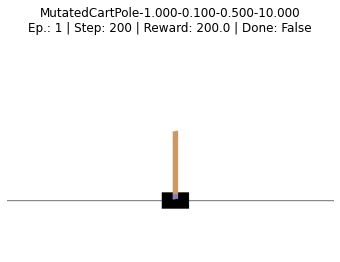

In [20]:
visualize_deviated_env(x_original, [0.0, 0.0, 0.0, 0.0], "gifs-DQN/default_env.gif")

In [21]:
# l-2 norm distance, the input x is in the original domain
def deviation_dist(x):
    """The variables of the objective function are normalized to [0, 1)"""
    return np.sqrt(np.sum((x - x_original) ** 2))

# wrapped objective function where input x is in [0, 1] and should be scaled to the original domain
def scaled_deviation_dist(x):
    return deviation_dist(scale_x(x, env_bounds))

### CMA for minimizing the STL robustness value given the bounded deviation

In [22]:
x0 = normalize_x(x_original, env_bounds)
sigma0 = 0.2

_, es1 = cma.fmin2(
    scaled_cma_min_STL_robustness,
    x0,
    sigma0,
    {'bounds': [0.0, 1.0], 'ftarget': min_STL_robustness_target, 'tolstagnation': 0,
     'tolx': 1e-5, 'timeout': 30 * 60},
)

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=137923, Thu Jul 28 14:43:47 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -2.400000190734863e+00 1.0e+00 2.50e-01  2e-01  3e-01 0:25.3
termination on ftarget=0.0 (Thu Jul 28 14:44:13 2022)
final/bestever f-value = -1.733194e+00 -2.400000e+00
incumbent solution: [0.5190820006453256, 0.16277797170074443]
std deviation: [0.23670667503330786, 0.30781049462952265]


In [23]:
es1.result

CMAEvolutionStrategyResult(xbest=array([0.53853752, 0.10692428]), fbest=-2.4000001907348634, evals_best=1, evaluations=7, iterations=1, xfavorite=array([0.519082  , 0.16277797]), stds=array([0.23670668, 0.30781049]), stop={'ftarget': 0.0})

In [24]:
x = es1.result.xbest
print("Counterexample deviation:", scale_x(x, env_bounds))
print("Deviation distance:", deviation_dist(scale_x(x, env_bounds)))
robustness, x_init = cma_min_STL_robustness(scale_x(x, env_bounds))
print("Counterexample initial state:", x_init)
print("Counterexample robustness value:", robustness)

Counterexample deviation: [1.1232213  3.03156123]
Deviation distance: 6.969528130215067
Counterexample initial state: [-0.03855038 -0.03330135 -0.03405994 -0.04841884]
Counterexample robustness value: -2.4000001907348634


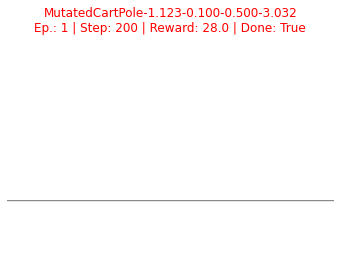

In [25]:
visualize_deviated_env(scale_x(x, env_bounds), x_init, "gifs-DQN/counterexample.gif")

### CMA-ES for minimizing the deviation s.t. the STL is violated (robustness value <= 0)

In [26]:
timeout = 30
num_tries = 3
min_dev = np.inf
min_x = None
for i in range(num_tries):
    print(f'\n================ Trial {i} ==============>')
    # set initial variable values to the default value
    x0 = normalize_x(x_original, env_bounds)
    sigma0 = 0.2

    cfun2 = cma.ConstrainedFitnessAL(
        scaled_deviation_dist,
        lambda x: [scaled_cma_min_STL_robustness(x)],
        find_feasible_first=True
    )
    _, es2 = cma.fmin2(
        cfun2,
        x0,
        sigma0,
        {'bounds': [0.0, 1.0], 'tolstagnation': 0, 'tolx': 1e-5,
         'timeout': timeout / num_tries * 60},
        callback=cfun2.update
    )
    
    print(es2.result)
    print(cfun2.best_feas.info)
    
    x = cfun2.best_feas.info['x']
    dev = deviation_dist(scale_x(x, env_bounds))
    if dev < min_dev:
        min_dev = dev
        min_x = x


================ Trial 0 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=115340, Thu Jul 28 14:44:27 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 9.924982204571684e-04 1.0e+00 1.67e-01  2e-01  2e-01 0:26.5
    2     12 1.437341876900621e-02 1.0e+00 1.27e-01  1e-01  1e-01 0:57.9
    3     18 2.629476374110931e+00 1.1e+00 1.63e-01  1e-01  2e-01 1:29.7
    4     24 -5.628621408516410e+01 1.8e+00 2.83e-01  2e-01  4e-01 1:50.8
    5     30 -4.746650157663137e+00 2.2e+00 3.49e-01  2e-01  4e-01 2:05.0
    7     42 9.457621729867515e-01 2.4e+00 2.91e-01  2e-01  3e-01 2:16.2
    8     48 9.409045647270053e-01 2.3e+00 3.13e-01  2e-01  4e-01 2:33.8
    9     54 -3.536878827217071e-01 2.3e+00 2.21e-01  1e-01  2e-01 3:00.1
   10     60 9.598426206318424e-01 2.3e+00 1.87e-01  8e-02  2e-01 3:17.5
   11     66 8.806393410521089e-01 2.7e+00 1.61e-01  6e-02  2e-01 3:42.0
   12     72 1.063000762317772e+00 2.8e+00 1.63e-01  5e-02  2e-

In [27]:
# c = es.countiter
# x = cfun.find_feasible(es)
# print("find_feasible took {} iterations".format(es.countiter - c))
# print("Solution:", scale_x(x, env_bounds))
# print("Worst-case robustness value:", scaled_cma_min_STL_robustness(x))  # show constraint violation values

In [28]:
# plt.rc('font', size=14) 

# es2.plot()

# fig = plt.gcf()
# fig.set_figwidth(18)
# fig.set_figheight(18)

In [29]:
x = min_x
print("Counterexample deviation:", scale_x(x, env_bounds))
print("Deviation distance:", deviation_dist(scale_x(x, env_bounds)))
robustness, x_init = cma_min_STL_robustness(scale_x(x, env_bounds))
print("Counterexample initial state:", x_init)
print("Counterexample robustness value:", robustness)

Counterexample deviation: [1.97358169 9.75914226]
Deviation distance: 1.0029325745063316
Counterexample initial state: [-0.04994919 -0.04989753 -0.03787372 -0.02021907]
Counterexample robustness value: -0.001587799059195788


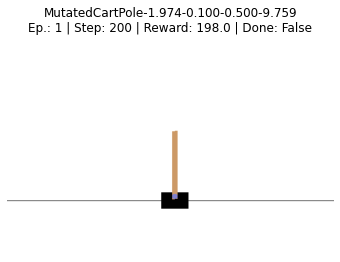

In [30]:
visualize_deviated_env(scale_x(x, env_bounds), x_init, "gifs-DQN/min_dev_counterexample.gif")

### CMA for finding the maximum deviation s.t. the agent is safe

In [39]:
timeout = 30
num_tries = 3
max_dev = -np.inf
max_x = None
for i in range(num_tries):
    print(f'\n================ Trial {i} ==============>')
    
    x0 = normalize_x(x_original, env_bounds)
    sigma0 = 0.2

    cfun3 = cma.ConstrainedFitnessAL(
        lambda x: -scaled_deviation_dist(x), # maximize distance
        lambda x: [-scaled_cma_min_STL_robustness(x)], # robustness >= 0
    #     find_feasible_first=True # assume the initial is already feasible
    )
    _, es3 = cma.fmin2(
        cfun3,
        x0,
        sigma0,
        {'bounds': [0.0, 1.0], 'tolstagnation': 0, 'tolx': 1e-5, 'timeout': timeout / num_tries * 60},
        callback=cfun3.update
    )
    
    print(es3.result)
    print(cfun3.best_feas.info)
    
    x = cfun3.best_feas.info['x']
    dev = deviation_dist(scale_x(x, env_bounds))
    if dev > max_dev:
        max_dev = dev
        max_x = x


================ Trial 0 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=227188, Thu Jul 28 16:17:25 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -7.466955043502383e+00 1.0e+00 2.50e-01  2e-01  3e-01 0:31.0
    2     12 -1.205118655066333e+01 1.8e+00 2.86e-01  2e-01  4e-01 1:01.2
    3     18 -1.194428562867022e+01 1.9e+00 3.06e-01  2e-01  4e-01 1:32.6
    4     24 -1.189420713280254e+01 1.6e+00 3.73e-01  4e-01  4e-01 2:03.0
    5     30 -1.191156777982009e+01 1.2e+00 2.86e-01  2e-01  2e-01 2:33.6
    6     36 -1.190392249540065e+01 1.0e+00 2.20e-01  2e-01  2e-01 3:04.0
    7     42 -1.179870245868902e+01 1.0e+00 2.20e-01  1e-01  2e-01 3:34.4
    8     48 -1.180036517231971e+01 1.3e+00 1.59e-01  9e-02  1e-01 4:04.9
    9     54 -1.181268620591059e+01 1.4e+00 1.23e-01  6e-02  9e-02 4:35.4
   10     60 -1.185456779656960e+01 1.6e+00 1.27e-01  5e-02  1e-01 5:06.1
   11     66 -1.174629697082057e+01 2.2e+00 1.61e-01  5e

In [40]:
x = max_x
print("Counterexample deviation:", scale_x(x, env_bounds))
print("Deviation distance:", deviation_dist(scale_x(x, env_bounds)))
robustness, x_init = cma_min_STL_robustness(scale_x(x, env_bounds))
print("Counterexample initial state:", x_init)
print("Counterexample robustness value:", robustness)

Counterexample deviation: [ 1.99923848 19.99993531]
Deviation distance: 10.049735504478123
Counterexample initial state: [-0.04996359 -0.04955586 -0.04874234 -0.03696456]
Counterexample robustness value: 0.08212206674929115


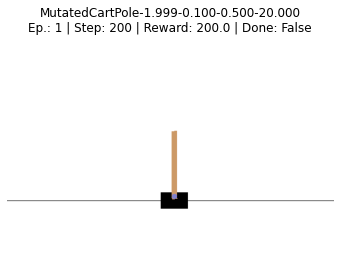

In [41]:
visualize_deviated_env(scale_x(x, env_bounds), x_init, "gifs-DQN/max_safe_deviation.gif")

### Plot the shape of the optimization space using grid

In [33]:
n_mass, n_force = (25, 25)

In [34]:
masses = np.linspace(masscart[0], masscart[1], n_mass)
forces = np.linspace(force_mag[0], force_mag[1], n_force)
masses, forces = np.meshgrid(masses, forces, indexing='ij')

In [35]:
min_STL_robustness_target = -np.inf
grid_data = np.zeros((n_mass, n_force))

for i in range(n_mass):
    for j in range(n_force):
        # treat xv[i,j], yv[i,j]
        m, f = masses[i, j], forces[i, j]
        robustness, _ = cma_min_STL_robustness([m, f])
        grid_data[i, j] = robustness

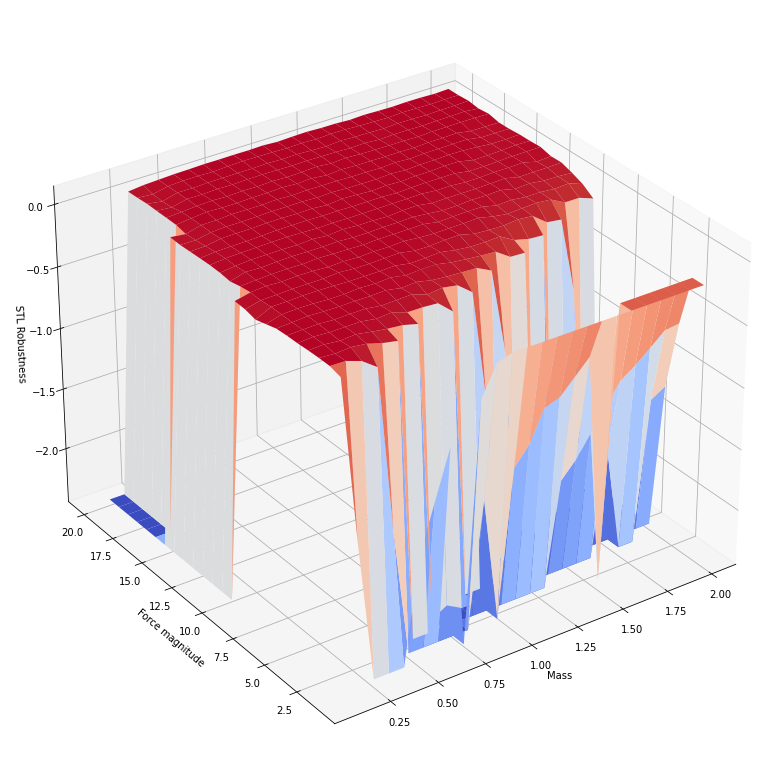

In [124]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(14, 14))
ax.plot_surface(masses, forces, grid_data, cmap=cm.coolwarm)
ax.set_xlabel('Mass')
ax.set_ylabel('Force magnitude')
ax.set_zlabel('STL Robustness')

ax.view_init(30, -125)
plt.savefig('gifs-DQN/robustness-landscape.png')
plt.show()

In [37]:
np.savetxt("rl_data/masses.csv", masses, delimiter=",")
np.savetxt("rl_data/forces.csv", forces, delimiter=",")
np.savetxt("rl_data/grid_data.csv", grid_data, delimiter=",")

### Understand the canyon like shape

In [129]:
idx = np.logical_and(np.logical_and(grid_data > -1.0, masses > 1.75), forces < 5)
canyon = np.stack((masses[idx], forces[idx]), axis=1); canyon

array([[1.7625    , 1.        ],
       [1.7625    , 1.79166667],
       [1.7625    , 2.58333333],
       [1.84166667, 1.        ],
       [1.84166667, 1.79166667],
       [1.84166667, 2.58333333],
       [1.92083333, 1.        ],
       [1.92083333, 1.79166667],
       [1.92083333, 2.58333333],
       [2.        , 1.        ],
       [2.        , 1.79166667],
       [2.        , 2.58333333]])

#### It shows that the angle is beyond the threshold, however the cart is still within the range.

In [130]:
x = canyon[0]
print("Counterexample deviation:", x)
print("Deviation distance:", deviation_dist(x))
robustness, x_init = cma_min_STL_robustness(x)
print("Counterexample initial state:", x_init)
print("Counterexample robustness value:", robustness)

Counterexample deviation: [1.7625 1.    ]
Deviation distance: 9.03224259251267
Counterexample initial state: [-0.04778415 -0.02075272 -0.0498502  -0.0475028 ]
Counterexample robustness value: -0.20943952189569023


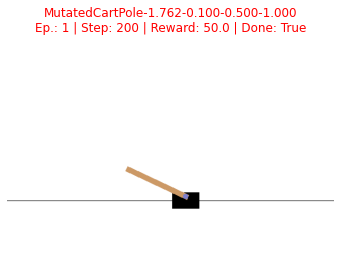

In [131]:
# visualize one
visualize_deviated_env(x, x_init, "gifs-DQN/canyon.gif")

### Using accelaration to understand the plot

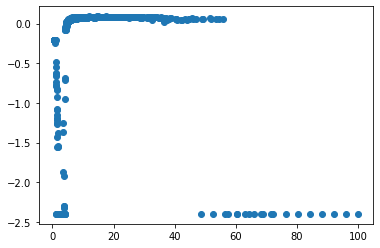

In [98]:
acc = forces / (masses + 0.1)
plt.scatter(acc.flatten(), grid_data.flatten())

In [99]:
# the overlap part with positive robustness
idx = np.logical_and(grid_data > 0, acc > 50)
overlap_pos = np.stack((masses[idx], forces[idx]), axis=1); overlap_pos

array([[ 0.17916667, 14.45833333],
       [ 0.17916667, 15.25      ],
       [ 0.25833333, 18.41666667],
       [ 0.25833333, 19.20833333],
       [ 0.25833333, 20.        ]])

In [100]:
x = overlap_pos[-1]
print("Counterexample deviation:", x)
print("Deviation distance:", deviation_dist(x))
robustness, x_init = cma_min_STL_robustness(x)
print("Counterexample initial state:", x_init)
print("Counterexample robustness value:", robustness)

Counterexample deviation: [ 0.25833333 20.        ]
Deviation distance: 10.02746575384052
Counterexample initial state: [-0.04260766 -0.04945267 -0.04677895 -0.04773954]
Counterexample robustness value: 0.054412359131531446


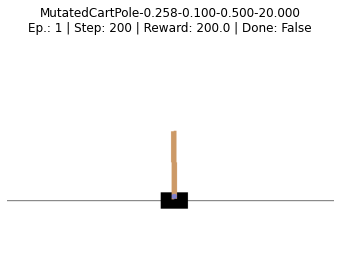

In [101]:
# visualize one
visualize_deviated_env(x, x_init, "gifs-DQN/overlap_pos.gif")

In [105]:
# the overlap part with negative robustness
idx = np.logical_and(np.logical_and(grid_data < -2, acc > 40), acc < 55)
overlap_neg = np.stack((masses[idx], forces[idx]), axis=1); overlap_neg

array([[ 0.1       ,  9.70833333],
       [ 0.1       , 10.5       ]])

In [106]:
x = overlap_neg[0]
print("Counterexample deviation:", x)
print("Deviation distance:", deviation_dist(x))
robustness, x_init = cma_min_STL_robustness(x)
print("Counterexample initial state:", x_init)
print("Counterexample robustness value:", robustness)

Counterexample deviation: [0.1        9.70833333]
Deviation distance: 0.9460810982386474


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py:150: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


Counterexample initial state: [-0.04778415 -0.02075272 -0.0498502  -0.0475028 ]
Counterexample robustness value: -2.4000001907348634


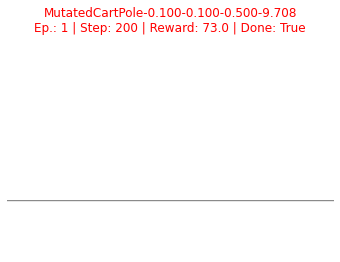

In [107]:
# visualize one
visualize_deviated_env(x, x_init, "gifs-DQN/overlap_neg.gif")